In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import socket
import sys

from sepsis_utils import sepsis_utils as su
from sepsis_utils import roc_utils as ru

# default colours for prettier plots
col = [[0.9047, 0.1918, 0.1988],
    [0.2941, 0.5447, 0.7494],
    [0.3718, 0.7176, 0.3612],
    [1.0000, 0.5482, 0.1000],
    [0.4550, 0.4946, 0.4722],
    [0.6859, 0.4035, 0.2412],
    [0.9718, 0.5553, 0.7741],
    [0.5313, 0.3359, 0.6523]];
marker = ['v','o','d','^','s','o','+']
ls = ['-','-','-','-','-','s','--','--']
%matplotlib inline

from __future__ import print_function

In [2]:
hostname=socket.gethostname()

if hostname=='alistair-pc70':
    sqluser = 'alistairewj'
else:
    sqluser = 'postgres'

dbname = 'mimic'
schema_name = 'mimiciii'

In [3]:
# load data
df = su.get_data(sqluser, dbname, schema_name)

Let's examine the columns in our dataframe:

In [4]:
df.columns

Index([u'icustay_id', u'intime', u'outtime', u'suspected_infection_time',
       u'positiveculture', u'age', u'gender', u'ethnicity',
       u'metastatic_cancer', u'diabetes', u'elixhauser_hospital', u'height',
       u'weight', u'bmi', u'first_service', u'hospital_expire_flag',
       u'thirtyday_expire_flag', u'angus', u'icu_los', u'hosp_los',
       u'lactate_max', u'sofa_si', u'sirs_si', u'lods_si', u'mlods_si',
       u'qsofa_si', u'sepsis3_si', u'sofa', u'sirs_24hours', u'lods',
       u'qsofa_24hours', u'sepsis3', u'mlods', u'sirs', u'qsofa',
       u'qsofa_sysbp_score', u'qsofa_gcs_score', u'qsofa_resprate_score',
       u'qsofa_norx', u'qsofa_sysbp_score_norx', u'qsofa_gcs_score_norx',
       u'qsofa_resprate_score_norx', u'icustay_num', u'adult', u'vent',
       u'race_black', u'race_other', u'is_male'],
      dtype='object')

We have: ICU intime/outtime, suspected infection time, whether the microbiology culture was positive, some demographics, comorbidities, outcomes, and the severity scores. 

The severity scores appear twice. With no suffix, the score is extracted at a [0, 24] hour window centered around ICU admission - except labs have an extended [-6, 24] hour window (i.e. 'sofa' is extracted in this way).

The second set of scores, with suffix 'si' (suspected infection), are extracted in a [-48, 24] hour window around the suspected_infection_time (i.e. 'sofa_si' is extracted in this window).

# Time of suspected infection

Suspected infection is defined as:

* Antibiotics within 72 hours of a culture
* A culture within 24 hours of antibiotics

We can extract antibiotic usage from the, PRESCRIPTIONS, INPUTEVENTS_MV and INPUTEVENTS_CV tables. We can extract time of blood cultures from the MICROBIOLOGYEVENTS table. Detail is given in defining-suspected-infection.ipynb.

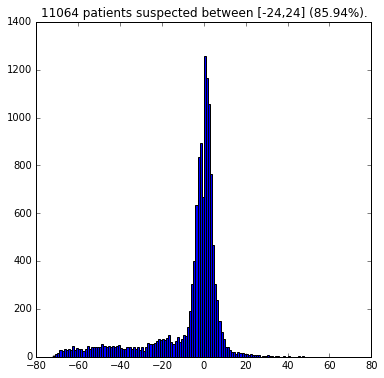

In [5]:
# distribution of time of infection
xi = np.linspace(-72, 72, 72*2+1)

idxKeep = ~df.suspected_infection_time.isnull()
tmp = (df.loc[idxKeep,'suspected_infection_time'] - df.loc[idxKeep,'intime']).values / np.timedelta64(1, 'h')

N_firstday = sum( (tmp>-24) & (tmp<24) )
plt.figure(figsize=[6,6])
plt.hist( tmp, bins=xi )
plt.title('{} patients suspected between [-24,24] ({:2.2f}%).'.format(
        N_firstday, N_firstday*100.0 / tmp.shape[0]))
plt.show()

In [6]:
print('Of the total {} patients, {} had a suspicion of infection {:2.2f}%.'.format(
        df.shape[0],
        np.sum(~df.suspected_infection_time.isnull()),
        np.sum(~df.suspected_infection_time.isnull()).astype(float)*100.0 / df.shape[0]
    ))

Of the total 61532 patients, 12874 had a suspicion of infection 20.92%.


We can see that most patients are suspected of infection either before, or at the time of their ICU admission. This motivates the decision to evaluate the performance of the scores at ICU admission.

# Cohort

The below code creates our cohort of interest. This cohort is used to apply inclusion criteria by means of an inner join. Inclusion criteria are:

* Adult patient, i.e. age >= 16
* First ICU stay for the patient
* Suspected of infection

In [7]:
print('{:5g} - total number of ICU stays in MIMIC.'.format(df.shape[0]))

idx = df.age > 1
N_rem = df.shape[0] - np.sum(idx)
print('{:5g}   include only adult ICU stays (removed {}).'.format(
        np.sum(idx), N_rem))

N_rem = np.sum(idx) - np.sum(idx & (df['icustay_num'] == 1))
idx = idx & (df['icustay_num'] == 1)
print('{:5g}   ... on their first ICU stay  (removed {}).'.format(
        np.sum(idx), N_rem))

N_rem = np.sum(idx) - np.sum(idx & ~(np.in1d(df['first_service'],['CSURG','VSURG','TSURG'])))
idx = idx & ~(np.in1d(df['first_service'],['CSURG','VSURG','TSURG']))
print('{:5g}   ... not in CSURG/VSURG/TSURG  (removed {}).'.format(
        np.sum(idx), N_rem))


N_rem = np.sum(idx) - np.sum(idx & (~df['suspected_infection_time'].isnull()))
idx = idx & (~df['suspected_infection_time'].isnull())
print('{:5g}   ... suspected of infection   (removed {}).'.format(
        np.sum(idx), N_rem))


print('\nOf the {} patients, {} had suspicion of infection {:2.2f}%.'.format(
        np.sum(idx)+N_rem,
        np.sum(idx),
        np.sum(idx)*100.0 / (np.sum(idx)+N_rem)
    ))
#idxRem = (df['suspected_infection_time']-df['intime'])<np.timedelta64(1,'D')
#N_rem = np.sum(idx) - np.sum(idx & idxRem)
#idx = idx & idxRem
#print('{:5g}   ... suspected before 1st day (removed {}).'.format(
#        np.sum(idx), N_rem))

df = df.loc[idx,:]

61532 - total number of ICU stays in MIMIC.
53432   include only adult ICU stays (removed 8100).
38606   ... on their first ICU stay  (removed 14826).
32701   ... not in CSURG/VSURG/TSURG  (removed 5905).
 6781   ... suspected of infection   (removed 25920).

Of the 32701 patients, 6781 had suspicion of infection 20.74%.


Patients in MIMIC have ages > 300 if their true age is > 89 (to comply with HIPAA regulations). Here we set their age to the median age for patients aged > 89, which is 91.4.

In [8]:
df.loc[df['age']>200, 'age'] = 91.4

In [9]:
# Call the print_demographics subfunction, which prints out a reasonably formatted table
su.print_demographics(df)

print('\nAlive vs. dead')
su.print_demographics(df, idx=(df.hospital_expire_flag.values==1))

print('\nNon-angus vs. angus')
su.print_demographics(df, idx=df.angus.values==1)

print('')

print('{:5g} have SIRS >= 2 ({:2.2f}%) on admission.'.format(
    (df.sirs.values >= 2).sum(),100.0*(df.sirs.values >= 2).mean()))

print('{:5g} have qSOFA >= 2 ({:2.2f}%) on admission.'.format(
    (df.qsofa.values >= 2).sum(),100.0*(df.qsofa.values >= 2).mean()))

print('  {:5g} have +1 for Vaso ({:2.2f}%).'.format(
    ((df.qsofa_sysbp_score.values-df.qsofa_sysbp_score_norx.values) >= 1).sum(),
        100.0*((df.qsofa_sysbp_score.values-df.qsofa_sysbp_score_norx.values) >= 1).mean()))

print('  {:5g} have +1 for MechVent ({:2.2f}%).'.format(
    ((df.qsofa_resprate_score.values-df.qsofa_resprate_score_norx.values) >= 1).sum(),
        100.0*((df.qsofa_resprate_score.values-df.qsofa_resprate_score_norx.values) >= 1).mean()))

print('  {:5g} have +1 for Vaso or MechVent ({:2.2f}%).'.format(
    ((df.qsofa.values-df.qsofa_norx.values) >= 1).sum(),
        100.0*((df.qsofa.values-df.qsofa_norx.values) >= 1).mean()))

print('  {:5g} have +1 for Vaso AND MechVent ({:2.2f}%).'.format(
    ((df.qsofa.values-df.qsofa_norx.values) >= 2).sum(),
        100.0*((df.qsofa.values-df.qsofa_norx.values) >= 2).mean()))

print('{:5g} have SOFA >= 2 ({:2.2f}%).'.format(
    (df.sofa.values >= 2).sum(),100.0*(df.sofa.values >= 2).mean()))

print('{:5g} have Sepsis-3 ({:2.2f}%).'.format(
    (df.sepsis3).sum(),100.0*(df.sepsis3).mean()))

print('{:5g} have LODS >= 2 ({:2.2f}%).'.format(
    (df.lods.values >= 2).sum(),100.0*(df.lods.values >= 2).mean()))

N                   	6781
age                 	65.30 [52.43, 78.26]
gender              	3779 (55.73%)
bmi                 	28.99 +- 9.00
Race                	
White               	4979 (73.43%)
Black               	 552 (8.14%)
Other               	1250 (18.43%)
elixhauser_hospital 	3.00 [0.00, 8.00]
qsofa               	2.00 [1.00, 2.00]
sirs                	2.00 [2.00, 3.00]
sofa                	4.00 [2.00, 7.00]
mlods               	3.00 [1.00, 5.00]
lactate_max         	2.94 +- 2.46
lactate measured    	1240 (18.29%)
lactate > 2         	3181 (46.91%)
vent                	3114 (45.92%)
icu_los             	2.60 [1.47, 5.09]
hosp_los            	8.17 [4.95, 13.94]
thirtyday_expire_flag	1139 (16.80%)
hospital_expire_flag	 948 (13.98%)

Alive vs. dead
N                   	5833     	 948     	     
age                 	64.21 [51.42, 77.18]	72.30 [59.73, 82.36]	< 0.001
gender              	3281 (56.25%)	 498 (52.53%)	0.036
bmi                 	29.09 +- 8.77	28.31 +- 10.29	0.107
ethnici

# Comparison of qSOFA vs SOFA

In [10]:
su.print_cm(df['qsofa'].values >= 2, df['sofa'].values >= 2,
           header1='q',header2='s') # print confusion matrix


Confusion matrix
      	q=0   	q=1   
s=0   	   771	   283	NPV=73.15
s=1   	  2279	  3448	PPV=60.21
   	25.28	92.41	Acc=62.22
   	Spec	Sens


# Baseline model + scores

The original paper evaluates a *baseline model* with the addition of the various severity scores. 

> To measure predictive validity, a baseline risk model was created for in-hospital mortality based on preinfection criteria using multivariable logistic regression. The baseline model included age (as a fractional polynomial), sex, race/ethnicity (black, white, or other), and the weighted Charlson comorbidity score (as fractional polynomial) as a measure of chronic comorbidities.

This baseline model includes:

* age (fractional polynomial)
* sex
* ethnicity
* Charlson comorbidities (fractional polynomial)

We will reproduce this model, with the following caveats:

1. We will build and evaluate the model on the same dataset, so our estimates are "apparent"
2. We will use Elixhauser comorbidities, not Charlson comorbidities
3. We may not have identical fractional polynomial terms (as we are rebuilding the model on our dataset)

The following code block extracts the covariates for the baseline model.

In [11]:
X_header = ['age','elixhauser_hospital','hospital_expire_flag','angus',
            'is_male','race_black','race_other',
            'qsofa','sofa','sepsis3','sirs','lods','mlods']

X = df[X_header].values

# we'll write out the design matrix for the MFP model here - this is used by the R code
np.savetxt('sepsis3-design-matrix.csv', X, fmt='%4.4f',
           delimiter=',', header=','.join(X_header), comments='')

# Save the data to file

The dataframes will be loaded directly from a file, rather than the database.

The `X` data which was written to 'sepsis3-design-matrix.csv' will be used by the `print_auc_table_baseline` function to evaluate the AUROC of the scores when incorporated with the baseline model.

In [12]:
df.to_csv('sepsis3-df.csv',sep=',',index=False)